# SARIMA Model for Forecasting Bitcoin Transaction Fees (Next 24 Hours)

This notebook builds and evaluates a SARIMA model to forecast the **Bitcoin transaction fee** over the **next 24 hours** , using **15-minute interval data** resampled from the raw mempool dataset.

### Why SARIMA?

During exploratory data analysis (EDA), we identified:
- **Daily seasonality patterns** in transaction fees (24-hour cycle),
- **Strong autocorrelation**, indicating temporal dependence.

Given these findings, the SARIMA model is an appropriate choice as it can model:
- Autoregressive and moving average components,
- **Seasonal effects**, such as daily cyclic behavior.

This notebook walks through the full modeling pipeline using SARIMA.


In [1]:
from sktime.forecasting.model_selection import (ExpandingWindowSplitter, SlidingWindowSplitter, temporal_train_test_split)
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.arima import AutoARIMA, ARIMA
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error, mean_squared_error, mean_absolute_error
from sktime.forecasting.model_evaluation import evaluate
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

## 1. Data Loading

We begin by loading the preprocessed dataset specifically prepared for SARIMA and HWES models.


In [2]:
df = pd.read_parquet('../data/processed/preprocessed_sarima.parquet')

df.head()

,mempool_blocks_blockSize,mempool_blocks_blockVSize,mempool_blocks_nTx,mempool_blocks_totalFees,mempool_blocks_medianFee,recommended_fee_fastestFee,recommended_fee_halfHourFee,recommended_fee_hourFee,recommended_fee_economyFee,recommended_fee_minimumFee,...,mempool_fee_histogram_bin_100_150,mempool_fee_histogram_bin_150_200,mempool_fee_histogram_bin_200_250,mempool_fee_histogram_bin_250_300,day_of_week,hour,minute,minute_of_day,tod_sin,tod_cos
timestamp,,,,,,,,,,,,,,,,,,,,,
2025-03-05 02:00:00,2.131827e+06,997874.250000,1030.000000,2.077770e+06,1.300139,2.000000,2.000000,2.000000,2.000000,2.0,...,0.0,0.0,0.0,0.0,2.0,2.0,14.0,134.0,0.551937,0.833886
2025-03-05 02:15:00,1.801526e+06,997925.916667,2627.000000,3.407913e+06,2.473960,3.000000,2.666667,2.666667,2.666667,2.0,...,0.0,0.0,0.0,0.0,2.0,2.0,24.0,144.0,0.587692,0.808889
2025-03-05 02:30:00,2.055350e+06,997965.916667,922.000000,1.855358e+06,1.355898,2.000000,2.000000,2.000000,2.000000,2.0,...,0.0,0.0,0.0,0.0,2.0,2.0,39.0,159.0,0.639338,0.768720
2025-03-05 02:45:00,2.006800e+06,997970.083333,1296.666667,2.167251e+06,1.536092,2.333333,2.333333,2.333333,2.333333,2.0,...,0.0,0.0,0.0,0.0,2.0,2.0,54.0,174.0,0.688245,0.725259
2025-03-05 03:00:00,1.773658e+06,997960.333333,2725.333333,3.462741e+06,2.467659,3.333333,3.000000,3.000000,3.000000,2.0,...,0.0,0.0,0.0,0.0,2.0,3.0,9.0,189.0,0.734206,0.678693


# 2. Autocorrelation, Partial Autocorrelation Analysis and Stationarity Check (ADF Test)

To determine the appropriate AR (autoregressive) and MA (moving average) orders, we examine the **Autocorrelation Function (ACF)** and **Partial Autocorrelation Function (PACF)** of the target variable. Before fitting a SARIMA model, we need to verify if the time series is **stationary** — a key assumption for ARIMA-family models. We use the **Augmented Dickey-Fuller (ADF) test**, which tests the null hypothesis that the time series has a unit root (i.e., is non-stationary).

(3968,)

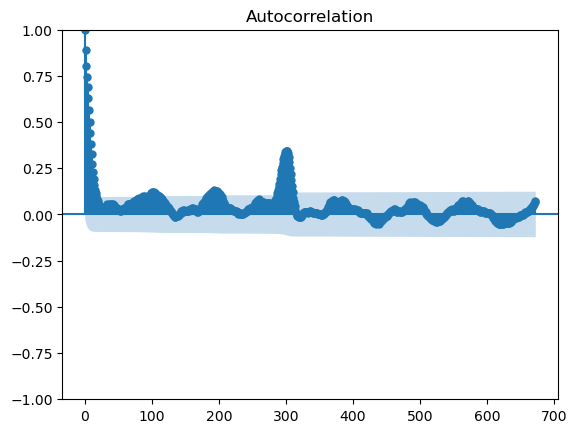

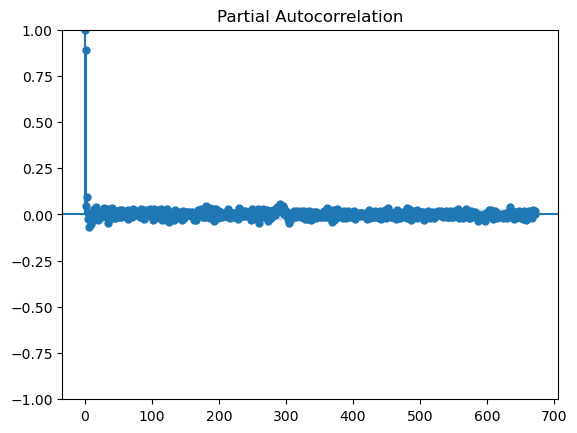

In [3]:
y = df["recommended_fee_fastestFee"]
plot_acf(y, lags=96*7)   
plot_pacf(y, lags=96*7)
y.shape


In [4]:
adfuller(y)[1]

np.float64(2.8563716542205644e-20)

The PACF cuts off at lag 1 and the ACF shows a significant lag-1 with slow decay, suggesting an ARIMA(1, 0, 1) structure. Clear seasonal spikes at lag 96 in the ACF indicate a seasonal pattern, so we set the seasonal order to (1, 0, 1, 96)

## 3. Train-Test Splits using Expanding and Sliding Window

### 3.1.1 Expanding Window Forecasting - Daily (optional)

Use expanding window to evaluate SARIMA performance across different time periods (7-day initial window, 1-day forecast).

In [5]:
# warnings.filterwarnings("ignore", category=FutureWarning)

# # Define forecast horizon: next 96 steps (15min × 96 = 1 day)
# fh = list(range(1, 97))

# # Create expanding window splitter
# expanding_cv = ExpandingWindowSplitter(
#     initial_window=96 * 7,   # 1 week of training data
#     step_length=96,          # move window forward by 1 day
#     fh=fh
# )

# # Initialize lists to store errors
# model_mae_list, model_rmse_list, model_mape_list = [], [], []
# baseline_mae_list, baseline_rmse_list, baseline_mape_list = [], [], []

# # Loop through each split and fit SARIMA model
# for i, (train_idx, test_idx) in enumerate(expanding_cv.split(y)):
#     y_train = y.iloc[train_idx]
#     y_test = y.iloc[test_idx]

#     # Log transform the training data
#     y_train_log = np.log1p(y_train)

#     # Initialize ARIMA forecaster
#     forecaster = AutoARIMA(sp=96, suppress_warnings=True)  # sp=96 for daily seasonality (15-min freq)
#     forecaster.fit(y_train)
#     y_pred = forecaster.predict(fh=fh)# Inverse log transform

#     # baseline
#     baseline_value = y_train.median()
#     y_pred_baseline = [baseline_value] * len(y_test)
    
#     # Compute and store errors
#     model_mae = mean_absolute_error(y_test, y_pred)
#     model_rmse = mean_squared_error(y_test, y_pred, squared=False)
#     model_mape = mean_absolute_percentage_error(y_test, y_pred)

#     # Compute baseline
#     baseline_mae = mean_absolute_error(y_test, y_pred_baseline)
#     baseline_rmse = mean_squared_error(y_test, y_pred_baseline, squared=False)
#     baseline_mape = mean_absolute_percentage_error(y_test, y_pred_baseline)
    
#     model_mae_list.append(model_mae)
#     model_rmse_list.append(model_rmse)
#     model_mape_list.append(model_mape)

#     baseline_mae_list.append(baseline_mae)
#     baseline_rmse_list.append(baseline_rmse)
#     baseline_mape_list.append(baseline_mape)

#     print(f"Fold {i+1}")
#     print(f"  Model     — MAE: {model_mae:.4f}, RMSE: {model_rmse:.4f}, MAPE: {model_mape:.2%}")
#     print(f"  Baseline  — MAE: {baseline_mae:.4f}, RMSE: {baseline_rmse:.4f}, MAPE: {baseline_mape:.2%}")

# # Final results
# print("\n=== Average over all folds ===")
# print(f"Model     — MAE: {np.mean(model_mae_list):.4f}, RMSE: {np.mean(model_rmse_list):.4f}, MAPE: {np.mean(model_mape_list):.2%}")
# print(f"Baseline  — MAE: {np.mean(baseline_mae_list):.4f}, RMSE: {np.mean(baseline_rmse_list):.4f}, MAPE: {np.mean(baseline_mape_list):.2%}")

### 3.1.2 Expanding Window Forecasting - Weekly

Use expanding window to evaluate SARIMA performance on a weekly basis (7-day initial window, 7-day forecast horizon), simulating generalization across multiple weekly periods.


In [6]:
fh = list(range(1, 96 + 1))

# Create expanding window splitter for weekly forecasting
expanding_cv_weekly = ExpandingWindowSplitter(
    initial_window=96 * 7,   # 1 week of training
    step_length=96 * 7,      # move window by 1 week
    fh=fh
)

# Initialize error containers
model_mae_list, model_rmse_list, model_mape_list = [], [], []
baseline_mae_list, baseline_rmse_list, baseline_mape_list = [], [], []

# Run cross-validation
for i, (train_idx, test_idx) in enumerate(expanding_cv_weekly.split(y)):
    y_train = y.iloc[train_idx]
    y_test = y.iloc[ test_idx]
    train_start_time = y.index[train_idx[0]]
    train_end_time = y.index[train_idx[-1]]
    test_start_time = y.index[test_idx[0]]
    test_end_time = y.index[test_idx[-1]]

    # SARIMA Model
    y_train_log = np.log1p(y_train)
    forecaster = ARIMA(order = (1, 0, 1), seasonal_order = (1, 0, 1, 96))
    forecaster.fit(y_train_log)
    y_pred_log = forecaster.predict(fh=fh)
    y_pred = np.expm1(y_pred_log)
    # Baseline: median of training data
    baseline_value = y_train.median()
    y_pred_baseline = [baseline_value] * len(y_test)

    # Model metrics
    model_mae = mean_absolute_error(y_test, y_pred)
    model_rmse = mean_squared_error(y_test, y_pred, squared=False)
    model_mape = mean_absolute_percentage_error(y_test, y_pred)

    # Baseline metrics
    baseline_mae = mean_absolute_error(y_test, y_pred_baseline)
    baseline_rmse = mean_squared_error(y_test, y_pred_baseline, squared=False)
    baseline_mape = mean_absolute_percentage_error(y_test, y_pred_baseline)

    # Store metrics
    model_mae_list.append(model_mae)
    model_rmse_list.append(model_rmse)
    model_mape_list.append(model_mape)

    baseline_mae_list.append(baseline_mae)
    baseline_rmse_list.append(baseline_rmse)
    baseline_mape_list.append(baseline_mape)

    print(f"Week {i+1}")
    print(f"  Train: {train_start_time} to {train_end_time}")
    print(f"  Test : {test_start_time} to {test_end_time}")
    print(f"  Model     — MAE: {model_mae:.4f}, RMSE: {model_rmse:.4f}, MAPE: {model_mape:.2%}")
    print(f"  Baseline  — MAE: {baseline_mae:.4f}, RMSE: {baseline_rmse:.4f}, MAPE: {baseline_mape:.2%}")


print("\n=== Average over all weekly folds ===")
print(f"Model     — MAE: {np.mean(model_mae_list):.4f}, RMSE: {np.mean(model_rmse_list):.4f}, MAPE: {np.mean(model_mape_list):.2%}")
print(f"Baseline  — MAE: {np.mean(baseline_mae_list):.4f}, RMSE: {np.mean(baseline_rmse_list):.4f}, MAPE: {np.mean(baseline_mape_list):.2%}")


Week 1
  Train: 2025-03-05 02:00:00 to 2025-03-12 01:45:00
  Test : 2025-03-12 02:00:00 to 2025-03-13 01:45:00
  Model     — MAE: 0.6806, RMSE: 0.6688, MAPE: 23.96%
  Baseline  — MAE: 0.6632, RMSE: 0.7581, MAPE: 20.71%
Week 2
  Train: 2025-03-05 02:00:00 to 2025-03-19 01:45:00
  Test : 2025-03-19 02:00:00 to 2025-03-20 01:45:00
  Model     — MAE: 0.9516, RMSE: 1.7082, MAPE: 25.98%
  Baseline  — MAE: 1.0625, RMSE: 2.1157, MAPE: 26.81%
Week 3
  Train: 2025-03-05 02:00:00 to 2025-03-26 01:45:00
  Test : 2025-03-26 02:00:00 to 2025-03-27 01:45:00
  Model     — MAE: 1.2642, RMSE: 4.0169, MAPE: 30.19%
  Baseline  — MAE: 1.2847, RMSE: 4.3750, MAPE: 29.18%
Week 4
  Train: 2025-03-05 02:00:00 to 2025-04-02 01:45:00
  Test : 2025-04-02 02:00:00 to 2025-04-03 01:45:00
  Model     — MAE: 1.0736, RMSE: 1.6537, MAPE: 68.28%
  Baseline  — MAE: 1.1042, RMSE: 1.7500, MAPE: 72.54%
Week 5
  Train: 2025-03-05 02:00:00 to 2025-04-09 01:45:00
  Test : 2025-04-09 02:00:00 to 2025-04-10 01:45:00
  Model     —

### Expanding Window Forecasting - Weekly Insight 

We evaluated SARIMA using an expanding window strategy, starting with 7 days of training data and expanding week by week, testing on the following day.
This approach simulates how the model adapts as more history becomes available over time.

- **Average Weekly RMSE**: 1.8928
- **Average Weekly MAE**: 0.9922
- **Average Weekly MAPE**: 40.48%

Observation:
The model generally performed on par with or better than the baseline.
A significant error spike in Week 3 highlights SARIMA’s sensitivity to sudden transaction fee volatility.
Performance in later weeks fluctuated, with high MAPE indicating challenges in modeling irregular demand patterns.


### 3.1.3 Expanding Window Forecasting - Weekly - Reverese
In order to see how spike may influence the result, we can do expanding window reversely, from the latest timestamps to the beggining

In [7]:
window_step = 96 * 7     # 1 week
fh = list(range(1, 96 + 1))  # 1 day forecast

# Always predict the last 24 hours
test_end = len(y)
test_start = test_end - 96
y_test = y.iloc[test_start:test_end]

# Reverse expanding window: grow the training window backward
train_end = test_start  # right before the test
max_train_size = train_end
n_folds = max_train_size // window_step

# Error containers
model_mae_list, model_rmse_list, model_mape_list = [], [], []

for i in range(1, n_folds + 1):
    train_start = max(0, train_end - i * window_step)
    y_train = y.iloc[train_start:train_end]
    train_start_time = y.index[train_start]
    train_end_time = y.index[train_end - 1]
    test_start_time = y.index[test_start]
    test_end_time = y.index[test_end - 1]

    # Model
    y_train_log = np.log1p(y_train)
    forecaster = ARIMA(order = (1, 0, 1), seasonal_order = (1, 0, 1, 96))
    forecaster.fit(y_train_log)
    y_pred_log = forecaster.predict(fh=fh)
    y_pred = np.expm1(y_pred_log)

    # Baseline
    baseline_value = y_train.median()
    y_pred_baseline = [baseline_value] * len(y_test)

    # Metrics
    model_mae = mean_absolute_error(y_test, y_pred)
    model_rmse = mean_squared_error(y_test, y_pred, squared=False)
    model_mape = mean_absolute_percentage_error(y_test, y_pred)

    baseline_mae = mean_absolute_error(y_test, y_pred_baseline)
    baseline_rmse = mean_squared_error(y_test, y_pred_baseline, squared=False)
    baseline_mape = mean_absolute_percentage_error(y_test, y_pred_baseline)

    print(f"Fold {i}: Training size = {len(y_train)}")
    print(f"  Train: {train_start_time} to {train_end_time}")
    print(f"  Test : {test_start_time} to {test_end_time}")
    print(f"  Model     — MAE: {model_mae:.4f}, RMSE: {model_rmse:.4f}, MAPE: {model_mape:.2%}")
    print(f"  Baseline  — MAE: {baseline_mae:.4f}, RMSE: {baseline_rmse:.4f}, MAPE: {baseline_mape:.2%}")

    model_mae_list.append(model_mae)
    model_rmse_list.append(model_rmse)
    model_mape_list.append(model_mape)


Fold 1: Training size = 672
  Train: 2025-04-07 10:00:00 to 2025-04-14 09:45:00
  Test : 2025-04-14 10:00:00 to 2025-04-15 09:45:00
  Model     — MAE: 0.9441, RMSE: 1.5068, MAPE: 43.35%
  Baseline  — MAE: 0.9549, RMSE: 1.5336, MAPE: 44.84%
Fold 2: Training size = 1344
  Train: 2025-03-31 10:00:00 to 2025-04-14 09:45:00
  Test : 2025-04-14 10:00:00 to 2025-04-15 09:45:00
  Model     — MAE: 0.9558, RMSE: 1.5560, MAPE: 43.43%
  Baseline  — MAE: 0.9549, RMSE: 1.5336, MAPE: 44.84%
Fold 3: Training size = 2016
  Train: 2025-03-24 10:00:00 to 2025-04-14 09:45:00
  Test : 2025-04-14 10:00:00 to 2025-04-15 09:45:00
  Model     — MAE: 0.9754, RMSE: 1.4691, MAPE: 49.61%
  Baseline  — MAE: 0.9549, RMSE: 1.5336, MAPE: 44.84%
Fold 4: Training size = 2688
  Train: 2025-03-17 10:00:00 to 2025-04-14 09:45:00
  Test : 2025-04-14 10:00:00 to 2025-04-15 09:45:00
  Model     — MAE: 0.9863, RMSE: 1.4704, MAPE: 51.74%
  Baseline  — MAE: 1.0035, RMSE: 1.4988, MAPE: 53.33%
Fold 5: Training size = 3360
  Train:

#### 3.1.4 Expanding Window Forecasting - Reverse Weekly Insight
- **Observation**:  
The SARIMA model performed best with recent training data, slightly outperforming the baseline in short-term forecasts. As more historical data was included, performance plateaued or worsened, especially in MAPE. This suggests that older data may introduce noise or reflect outdated patterns, reducing forecast accuracy.

### 3.2.1 Sliding Window Forecasting - Daily (optional)

To further assess temporal stability and generalization, we apply a **sliding window** strategy using a fixed 7-day training window and 1-day test window (96 × 15-minute intervals).  
This allows us to evaluate SARIMA performance across multiple time segments without expanding the training data size.

In [8]:
# # Define forecast horizon: next 96 steps (15min × 96 = 1 day)
# fh = list(range(1, 97))

# # Create sliding window splitter
# sliding_cv = SlidingWindowSplitter(
#     window_length=96 * 7,  # fixed 7-day training window
#     step_length=96,        # move forward by 1 day
#     fh=fh
# )

# # Initialize error containers
# model_mae_list, model_rmse_list, model_mape_list = [], [], []
# baseline_mae_list, baseline_rmse_list, baseline_mape_list = [], [], []

# # Loop through each split and fit SARIMA model
# for i, (train_idx, test_idx) in enumerate(sliding_cv.split(y)):
#     y_train = y.iloc[train_idx]
#     y_test = y.iloc[test_idx]

#     # SARIMA model
#     y_train_log = np.log1p(y_train)
#     forecaster = AutoARIMA(sp=96, suppress_warnings=True)  # sp=96 for daily seasonality (15-min freq)
#     forecaster.fit(y_train)
#     y_pred = forecaster.predict(fh=fh)

#     # Baseline (median of training set)
#     baseline_value = y_train.median()
#     y_pred_baseline = [baseline_value] * len(y_test)

#     # Model metrics
#     model_mae = mean_absolute_error(y_test, y_pred)
#     model_rmse = mean_squared_error(y_test, y_pred, squared=False)
#     model_mape = mean_absolute_percentage_error(y_test, y_pred)

#     # Baseline metrics
#     baseline_mae = mean_absolute_error(y_test, y_pred_baseline)
#     baseline_rmse = mean_squared_error(y_test, y_pred_baseline, squared=False)
#     baseline_mape = mean_absolute_percentage_error(y_test, y_pred_baseline)

#     # Store
#     model_mae_list.append(model_mae)
#     model_rmse_list.append(model_rmse)
#     model_mape_list.append(model_mape)

#     baseline_mae_list.append(baseline_mae)
#     baseline_rmse_list.append(baseline_rmse)
#     baseline_mape_list.append(baseline_mape)

#     print(f"Fold {i+1}")
#     print(f"  Model     — MAE: {model_mae:.4f}, RMSE: {model_rmse:.4f}, MAPE: {model_mape:.2%}")
#     print(f"  Baseline  — MAE: {baseline_mae:.4f}, RMSE: {baseline_rmse:.4f}, MAPE: {baseline_mape:.2%}")

# # Final summary
# print("\n=== Average over all sliding folds ===")
# print(f"Model     — MAE: {np.mean(model_mae_list):.4f}, RMSE: {np.mean(model_rmse_list):.4f}, MAPE: {np.mean(model_mape_list):.2%}")
# print(f"Baseline  — MAE: {np.mean(baseline_mae_list):.4f}, RMSE: {np.mean(baseline_rmse_list):.4f}, MAPE: {np.mean(baseline_mape_list):.2%}")


### 3.2.2 Sliding Window Forecasting – Weekly

Use sliding window to evaluate SARIMA performance across fixed-length time segments  
(7-day training window, 1-day forecast).


In [10]:
fh = list(range(1, 96 + 1))

# Create sliding window splitter for weekly forecasting
sliding_cv_weekly = SlidingWindowSplitter(
    window_length=96 * 7,  # 1 week of training
    step_length=96 * 7,    # move window by 1 week
    fh=fh
)

# Initialize error containers
model_mae_list, model_rmse_list, model_mape_list = [], [], []
baseline_mae_list, baseline_rmse_list, baseline_mape_list = [], [], []

# Run cross-validation
for i, (train_idx, test_idx) in enumerate(sliding_cv_weekly.split(y)):
    y_train = y.iloc[train_idx]
    y_test = y.iloc[test_idx]
    train_start_time = y.index[train_idx[0]]
    train_end_time = y.index[train_idx[-1]]
    test_start_time = y.index[test_idx[0]]
    test_end_time = y.index[test_idx[-1]]

    # SARIMA model
    y_train_log = np.log1p(y_train)
    forecaster = ARIMA(order = (1, 0, 1), seasonal_order = (1, 0, 1, 96))
    forecaster.fit(y_train_log)
    y_pred_log = forecaster.predict(fh=fh)
    y_pred = np.expm1(y_pred_log)

    # Baseline: median of training data
    baseline_value = y_train.median()
    y_pred_baseline = [baseline_value] * len(y_test)

    # Model metrics
    model_mae = mean_absolute_error(y_test, y_pred)
    model_rmse = mean_squared_error(y_test, y_pred, squared=False)
    model_mape = mean_absolute_percentage_error(y_test, y_pred)

    # Baseline metrics
    baseline_mae = mean_absolute_error(y_test, y_pred_baseline)
    baseline_rmse = mean_squared_error(y_test, y_pred_baseline, squared=False)
    baseline_mape = mean_absolute_percentage_error(y_test, y_pred_baseline)

    # Store
    model_mae_list.append(model_mae)
    model_rmse_list.append(model_rmse)
    model_mape_list.append(model_mape)

    baseline_mae_list.append(baseline_mae)
    baseline_rmse_list.append(baseline_rmse)
    baseline_mape_list.append(baseline_mape)

    # Output for this fold
    print(f"  Train: {train_start_time} to {train_end_time}")
    print(f"  Test : {test_start_time} to {test_end_time}")
    print(f"  Model     — MAE: {model_mae:.4f}, RMSE: {model_rmse:.4f}, MAPE: {model_mape:.2%}")
    print(f"  Baseline  — MAE: {baseline_mae:.4f}, RMSE: {baseline_rmse:.4f}, MAPE: {baseline_mape:.2%}")

# Final summary
print("\n=== Average over all weekly sliding folds ===")
print(f"Model     — MAE: {np.mean(model_mae_list):.4f}, RMSE: {np.mean(model_rmse_list):.4f}, MAPE: {np.mean(model_mape_list):.2%}")
print(f"Baseline  — MAE: {np.mean(baseline_mae_list):.4f}, RMSE: {np.mean(baseline_rmse_list):.4f}, MAPE: {np.mean(baseline_mape_list):.2%}")


  Train: 2025-03-05 02:00:00 to 2025-03-12 01:45:00
  Test : 2025-03-12 02:00:00 to 2025-03-13 01:45:00
  Model     — MAE: 0.6806, RMSE: 0.6688, MAPE: 23.96%
  Baseline  — MAE: 0.6632, RMSE: 0.7581, MAPE: 20.71%
  Train: 2025-03-12 02:00:00 to 2025-03-19 01:45:00
  Test : 2025-03-19 02:00:00 to 2025-03-20 01:45:00
  Model     — MAE: 0.9750, RMSE: 1.7558, MAPE: 26.66%
  Baseline  — MAE: 1.0625, RMSE: 2.1157, MAPE: 26.81%
  Train: 2025-03-19 02:00:00 to 2025-03-26 01:45:00
  Test : 2025-03-26 02:00:00 to 2025-03-27 01:45:00
  Model     — MAE: 1.3679, RMSE: 3.8602, MAPE: 37.12%
  Baseline  — MAE: 1.3333, RMSE: 4.0278, MAPE: 34.05%
  Train: 2025-03-26 02:00:00 to 2025-04-02 01:45:00
  Test : 2025-04-02 02:00:00 to 2025-04-03 01:45:00
  Model     — MAE: 0.9141, RMSE: 1.3218, MAPE: 55.99%
  Baseline  — MAE: 0.8958, RMSE: 1.3056, MAPE: 49.88%
  Train: 2025-04-02 02:00:00 to 2025-04-09 01:45:00
  Test : 2025-04-09 02:00:00 to 2025-04-10 01:45:00
  Model     — MAE: 0.9260, RMSE: 1.4331, MAPE: 4

#### 3.2.2 Sliding Window Forecasting - Weekly Insight

The SARIMA model was evaluated using sliding window cross-validation with 1-week training and 1-day testing windows.

- **Average MAE:**  0.9727
- **Average RMSE:** 1.8079
- **Average MAPE:** 36.97%
  
A notable spike in Week 3 (RMSE = 3.8602) suggests a period of high transaction fee volatility. While SARIMA effectively captures the regular intraday seasonality, it struggles to adapt to sudden, irregular fee spikes, limiting its robustness during turbulent periods.

Overall, the model performs better than the baseline in terms of RMSE and MAE but shows limited resilience to unexpected fluctuations.



## 4. Forecasting and Evaluation

We fit a final SARIMA model using all data except for the last day, and test on the last day data.

In [13]:
y_train, y_test = temporal_train_test_split(y, test_size=96)

# --- SARIMA Model ---
y_train_log = np.log1p(y_train)
forecaster = ARIMA(order=(1, 0, 1), seasonal_order=(1, 0, 1, 96))
forecaster.fit(y_train_log)

fh = list(range(1, 97))
y_pred_log = forecaster.predict(fh=fh)
y_pred = np.expm1(y_pred_log)

# --- Baseline: Median of training data ---
baseline_value = y_train.median()
y_pred_baseline = [baseline_value] * len(y_test)

# --- Model Metrics ---
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

# --- Baseline Metrics ---
baseline_rmse = mean_squared_error(y_test, y_pred_baseline, squared=False)
baseline_mae = mean_absolute_error(y_test, y_pred_baseline)
baseline_mape = mean_absolute_percentage_error(y_test, y_pred_baseline)

# --- Print Results ---
print("=== SARIMA Model ===")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.2%}")

print("\n=== Baseline (Median) ===")
print(f"RMSE: {baseline_rmse:.4f}")
print(f"MAE: {baseline_mae:.4f}")
print(f"MAPE: {baseline_mape:.2%}")

=== SARIMA Model ===
RMSE: 1.4818
MAE: 0.9958
MAPE: 53.09%

=== Baseline (Median) ===
RMSE: 1.4988
MAE: 1.0035
MAPE: 53.33%


## 5. Forecast Visualization

We plot the SARIMA model's 1-day forecast against the actual observations.


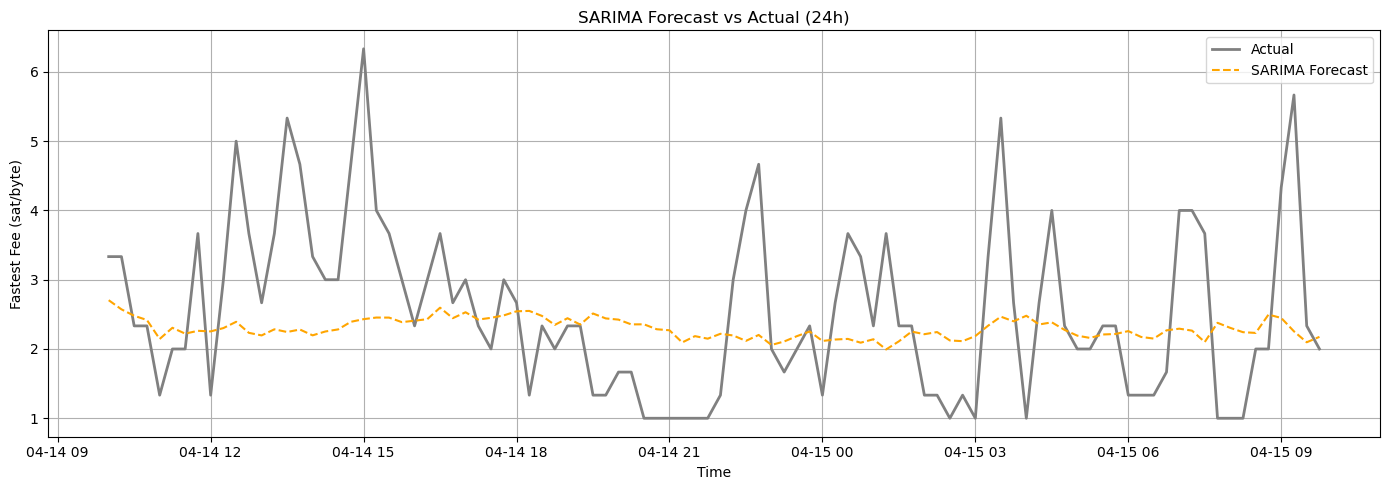

In [12]:
plt.figure(figsize=(14, 5))

plt.plot(y_test.index, y_test.values, label="Actual", color="grey", linewidth=2)
plt.plot(y_test.index, y_pred.values, label="SARIMA Forecast", color="orange", linestyle="--")

plt.title("SARIMA Forecast vs Actual (24h)")
plt.xlabel("Time")
plt.ylabel("Fastest Fee (sat/byte)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
